# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In [1]:
# Required python module

import numpy as np
from scipy import stats
import pickle
from textwrap import wrap
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
import os
from tensorflow.contrib.layers import flatten
import matplotlib.image as mpimg
import cv2


/home/demo/anaconda3/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


---
## Step 0: Load The Data

In [2]:
# Load pickled data
training_file = "traffic-signs-data/train.p"
validation_file= "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)


X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. 

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set 

In [3]:
# Number of training examples
n_train = len(train['labels'])

# Number of validation examples
n_validation = len(valid['labels'])

# Number of testing examples.
n_test = len(test['labels'])

# What's the shape of an traffic sign image?
image_shape = (32, 32, 3)

# How many unique classes/labels there are in the dataset.
n_classes = 43

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

We would like to know the distribution of classes in the training, validation and test set. Are they similar or are there more examples of some classes than others?

In [4]:
# get a dictionary whose keys are the sign id's e.g.,'0','1','42'.etc and whose values are the sign names

with open('signnames.csv', 'r') as f:
    """
    We start reading from line 1 not 0 since the line 0 contains the column titles
    Note: we use line.strip() to remove all whitespaces at the start and end, including spaces, tabs, 
    newlines and carriage returns. It allows our code to deal with unexpected extra whitespace inserted 
    into the file.    
    """
    first_data_line_index = 1
    id_names = dict(line.strip().split(',') for line in f.readlines()[first_data_line_index:])

print("ID\t Name")
print("---\t ---------------")
for i in id_names:
    print(i, "\t",id_names[i])

ID	 Name
---	 ---------------
0 	 Speed limit (20km/h)
1 	 Speed limit (30km/h)
2 	 Speed limit (50km/h)
3 	 Speed limit (60km/h)
4 	 Speed limit (70km/h)
5 	 Speed limit (80km/h)
6 	 End of speed limit (80km/h)
7 	 Speed limit (100km/h)
8 	 Speed limit (120km/h)
9 	 No passing
10 	 No passing for vehicles over 3.5 metric tons
11 	 Right-of-way at the next intersection
12 	 Priority road
13 	 Yield
14 	 Stop
15 	 No vehicles
16 	 Vehicles over 3.5 metric tons prohibited
17 	 No entry
18 	 General caution
19 	 Dangerous curve to the left
20 	 Dangerous curve to the right
21 	 Double curve
22 	 Bumpy road
23 	 Slippery road
24 	 Road narrows on the right
25 	 Road work
26 	 Traffic signals
27 	 Pedestrians
28 	 Children crossing
29 	 Bicycles crossing
30 	 Beware of ice/snow
31 	 Wild animals crossing
32 	 End of all speed and passing limits
33 	 Turn right ahead
34 	 Turn left ahead
35 	 Ahead only
36 	 Go straight or right
37 	 Go straight or left
38 	 Keep right
39 	 Keep left
40 	 Ro

In [5]:
#######################################
#
# Build Labels 
#
#######################################

# get a list `signs_by_id_*` where `signs_by_id_*[i]` is a list of all signs with id `i` in set *
signs_by_id_train = [[sign_id for sign_id, sign_class in enumerate(y_train) if sign_class == class_id] 
                     for class_id in range(n_classes)]
signs_by_id_valid = [[sign_id for sign_id, sign_class in enumerate(y_valid) if sign_class == class_id] 
                     for class_id in range(n_classes)]
signs_by_id_test = [[sign_id for sign_id, sign_class in enumerate(y_test) if sign_class == class_id] 
                    for class_id in range(n_classes)]

assert len(signs_by_id_train) == n_classes
assert len(signs_by_id_valid) == n_classes
assert len(signs_by_id_test) == n_classes

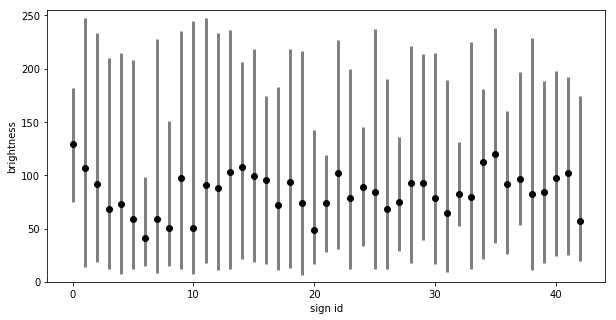

In [6]:
#######################################
#
# Explore Data Statistics (mean, max, min)
#
#######################################
sign_examples = []

imag_stats = []
for i in range(n_classes):
    n_examples = len(signs_by_id_train[i])
    means = np.zeros(n_examples)
    for j in range(n_examples):
        means[j] = np.mean(X_train[signs_by_id_train[i][j], :, :, :])
        
    # pick example image that has appropriate brightness.
    example_index = np.where(means > 80)[0][0] 
    imag_stats.append({'mean':np.mean(means), 
                       'max': np.max(means),
                       'min': np.min(means),
                       'image_sample': X_train[signs_by_id_train[i][example_index], :, :, :]})

# Visualize the statistics
means = np.array([imag_stats[i]['mean'] for i in range(43)])
mins = np.array([imag_stats[i]['min'] for i in range(43)])
maxes = np.array([imag_stats[i]['max'] for i in range(43)])

plt.figure(figsize=(10, 5))
plt.errorbar(np.arange(43), means, [means - mins, maxes - means], fmt='ok', ecolor='gray', lw=3)
plt.xlabel('sign id')
plt.ylabel('brightness')
plt.ylim(0, 255)
plt.show()

As it can be seen from the plot above, the range of brightness in some sign ids is much larger than others.

Some id examples are pretty dark such as id = 6

The example image picked for each id has the mode brightness > 80 which seems to be almost the maximum brightness available for all ids.

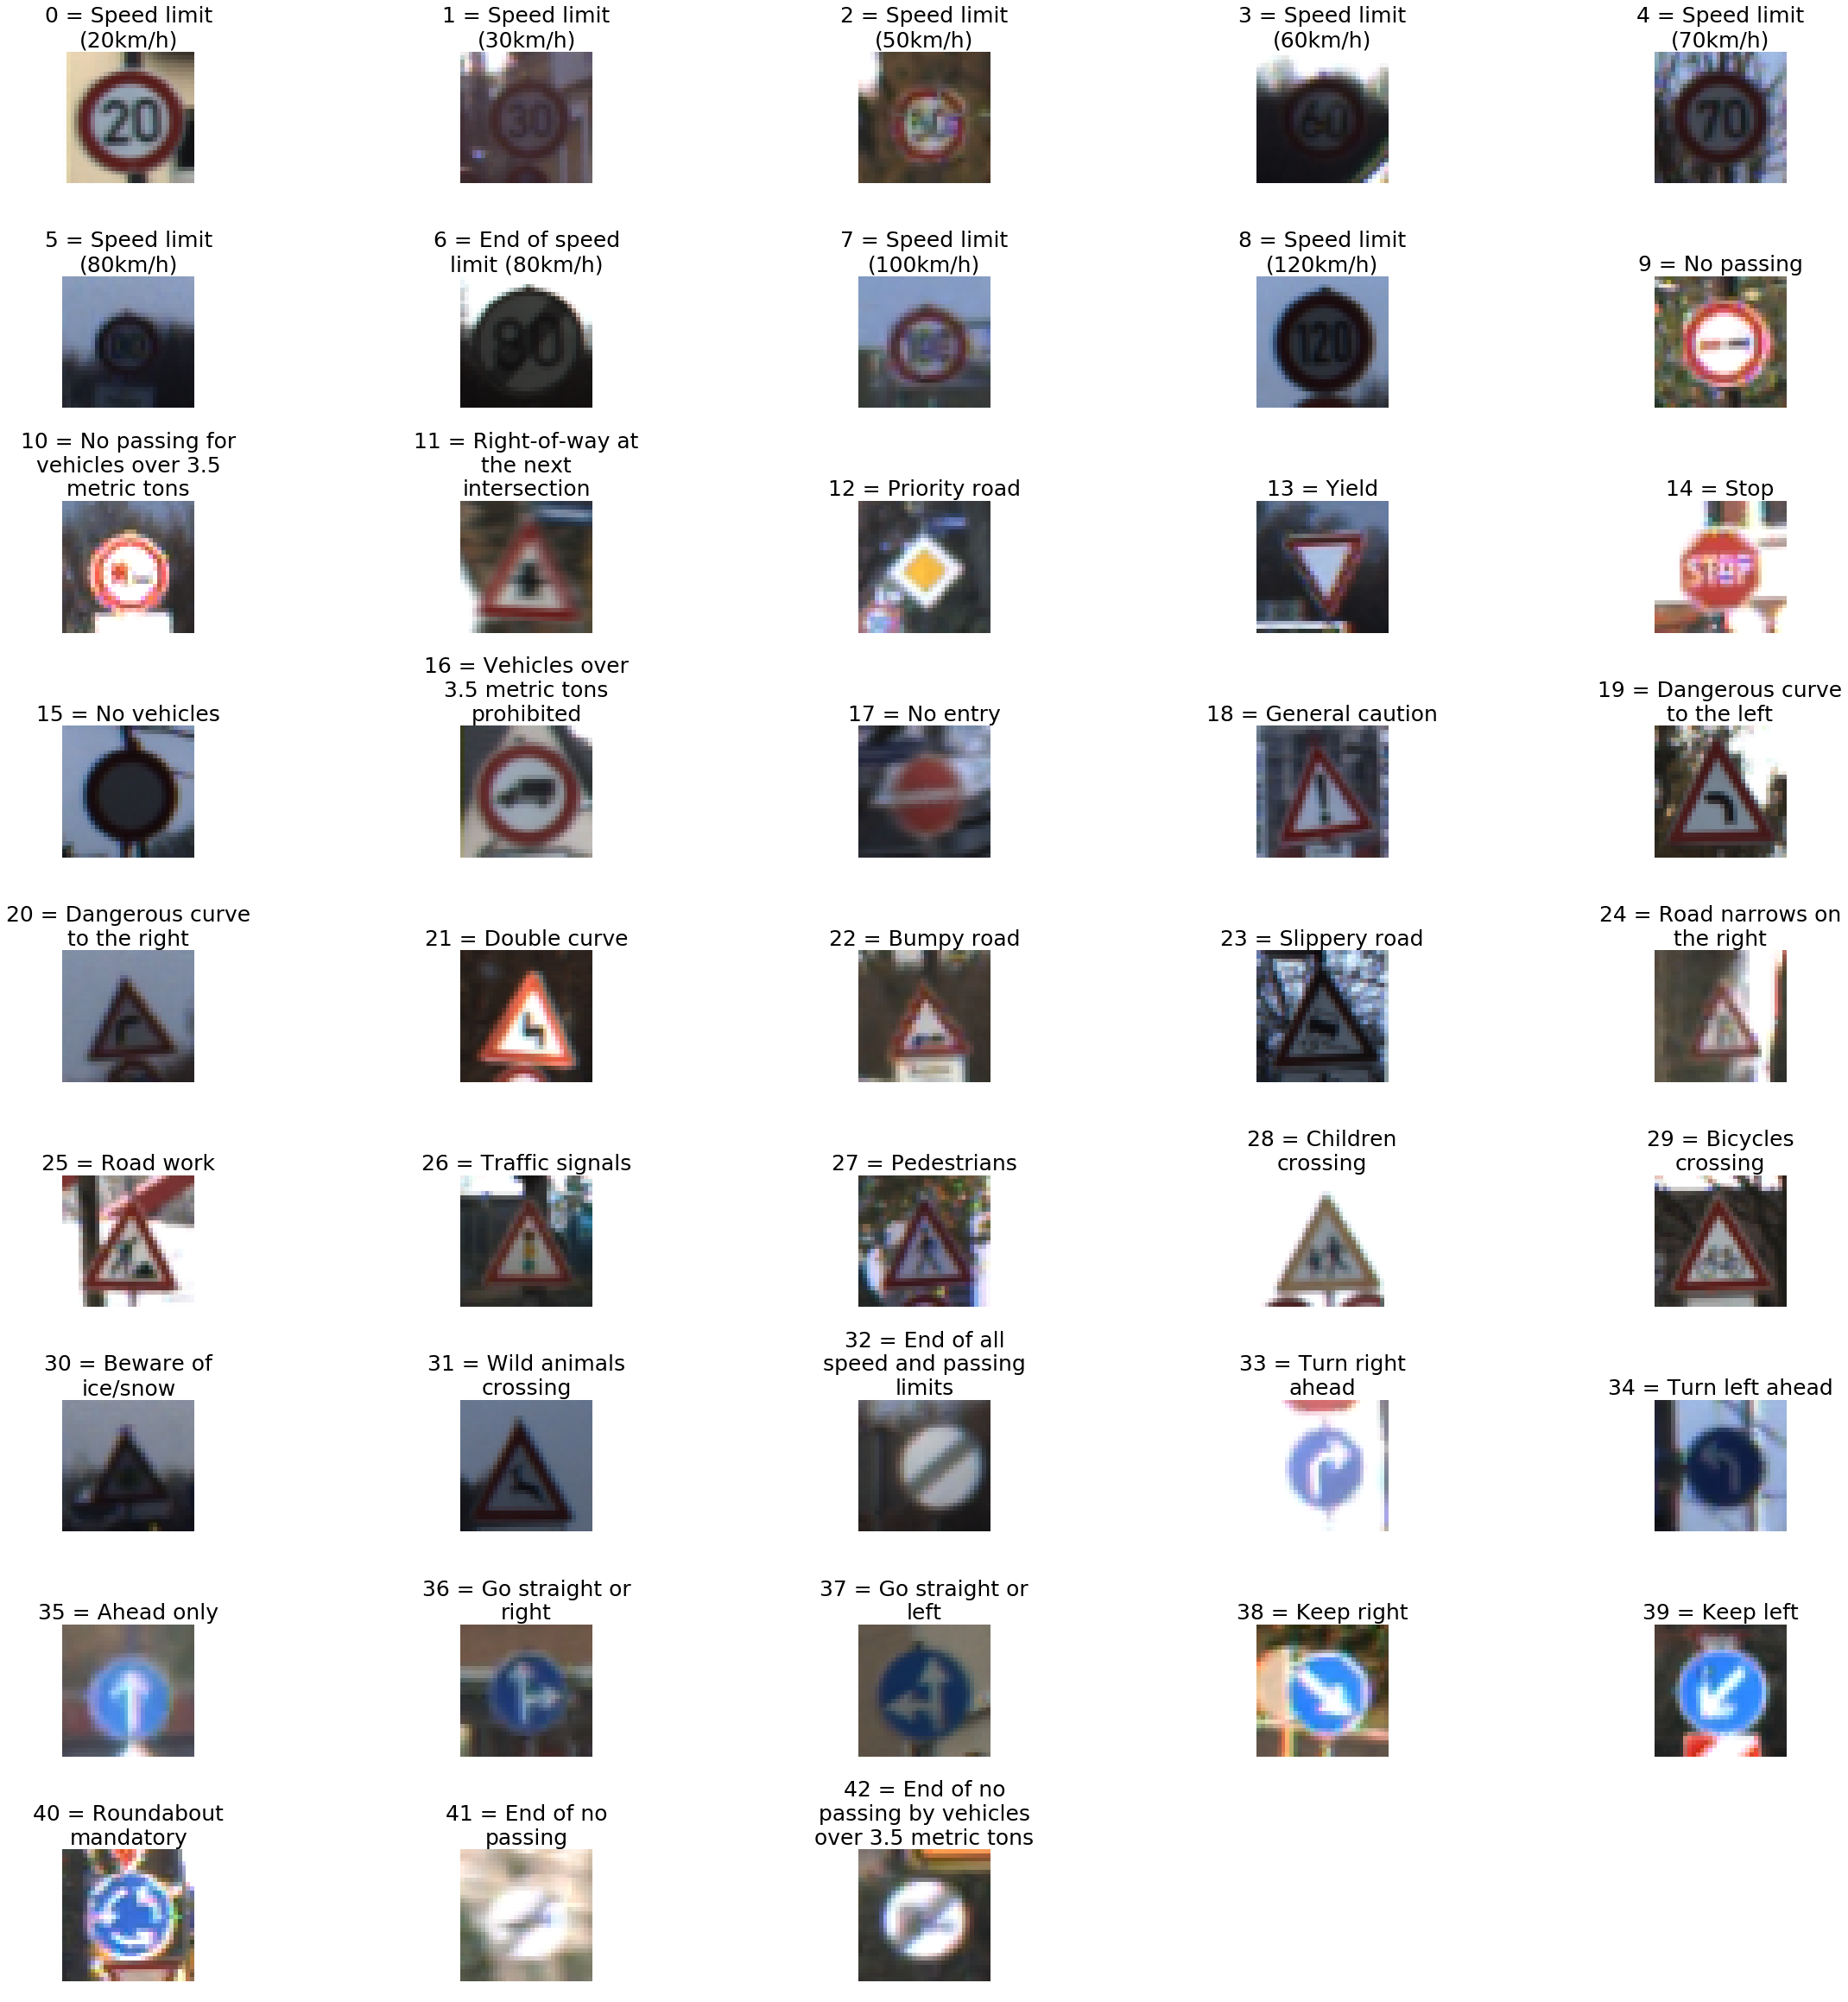

In [7]:
# plot an example of each sign type
rows = 9
cols = 5

plt.figure(1, figsize=(32,32))
for i in range(43):
    plt.subplot(rows, cols, i+1)
    plt.title("\n".join(wrap('{0} = {1}'.format(i, id_names[str(i)]), 20)), fontsize=25)
    example_index = np.where(means == stats.mode(means)[0][0])[0][0]  
    plt.imshow(imag_stats[i]['image_sample'])
    plt.axis('off')
    

plt.tight_layout(pad=0., w_pad=0., h_pad=1.0)
plt.show()

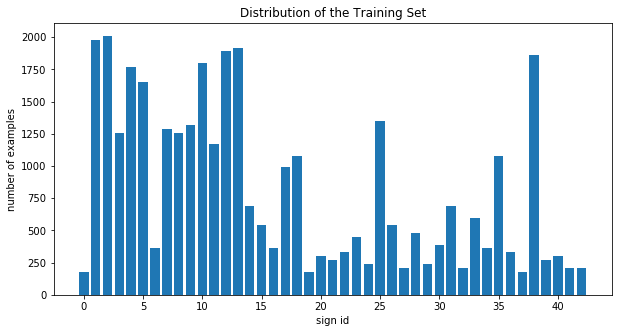

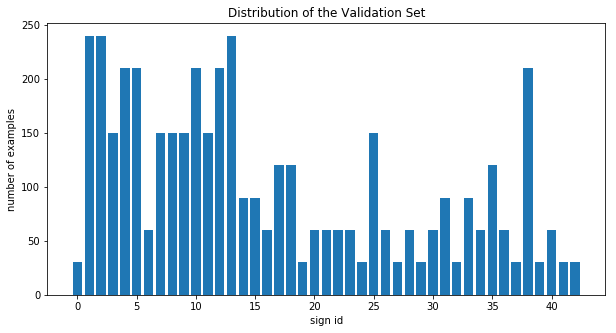

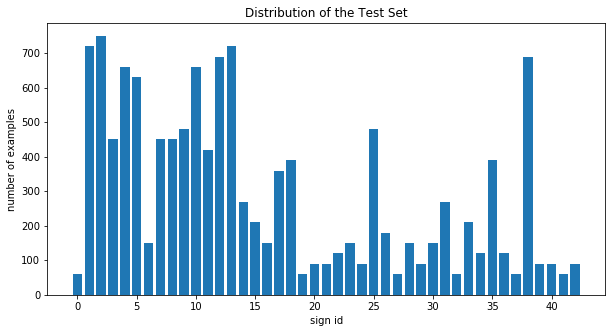

In [8]:
plt.figure(figsize=(10, 5))
plt.bar(range(n_classes), [len(s) for s in signs_by_id_train], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Training Set')
plt.xlabel('sign id')
plt.ylabel('number of examples')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(n_classes), [len(s) for s in signs_by_id_valid], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Validation Set')
plt.xlabel('sign id')
plt.ylabel('number of examples')
plt.show()

plt.figure(figsize=(10, 5))
plt.bar(range(n_classes), [len(s) for s in signs_by_id_test], align='center')
plt.xticks(range(0, n_classes, 5))
plt.title('Distribution of the Test Set')
plt.xlabel('sign id')
plt.ylabel('number of examples')
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

In [9]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

def preprocess_features(x):
    mu = np.mean(x)
    std = np.std(x)
    normalized = (x - mu)/std
    return normalized


In [10]:
X_train = np.array([preprocess_features(x) for x in X_train])
X_valid = np.array([preprocess_features(x) for x in X_valid])
X_test = np.array([preprocess_features(x) for x in X_test])

### Model Architecture
Input shape is 32x32x3

**Layer 1: Convolutional.** 

Weight shape is 5x5x3x6 --> The output shape should be 28x28x6.

**Activation.** Relu activation function.

**Pooling.** Stride of 2 --> The output shape should be 14x14x6.

**Layer 2: Convolutional.** 

Weight shape is 5x5x6x16 --> The output shape should be 10x10x16.

**Activation.** Relu activation function.

**Pooling.** Stride of 2 --> The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. 
5x5x16 --> 400

**Layer 3: Fully Connected.** 
This should have 400 inputs and 120 outputs.

**Activation.** Relu activation function.

**Layer 4: Fully Connected.** 
This should have 120 inputs aand 84 outputs.

**Activation.** Relu activation function.

**Layer 5: Fully Connected (Logits).** 

This should have 84 inputs and 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

In [11]:
### Define your architecture here.

def conv2d(x, w_shape, mu, sigma, stride, name): 
    """
    Construct 2D convolutional layer
    """        
    w_name = name+"_weights"
    b_name = name+"_biases"
    cnn_name = name+"_conv"
    normal_var = tf.truncated_normal(w_shape, mean=mu, stddev=sigma)
    
    weights = tf.Variable(normal_var, name=w_name)    
    biases = tf.Variable(tf.zeros(w_shape[3]), name=b_name)    
    strides = [1, stride, stride, 1]    
    padding = 'VALID'
    return tf.nn.conv2d(x, weights, strides, padding, name=cnn_name) + biases    
    
def activation(x, name=""):    
    return tf.nn.relu(x, name=name+"_relu")

def maxpool2d(x, k=2, name=""):
    return tf.nn.max_pool(x, 
                          ksize=[1, k, k, 1], 
                          strides=[1, k, k, 1], 
                          padding='SAME', 
                          name=name+"_pool")

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)


def fullyconnected(x, w_shape, mu, sigma, name):
    w_name = name+"_weights"
    b_name = name+"_biases"
    weights = tf.Variable(tf.truncated_normal(w_shape, mu, sigma), name=w_name)
    biases = tf.Variable(tf.zeros(w_shape[1]), name=b_name)
    return tf.add(tf.matmul(x, weights), biases)

def flatten(x):
    return tf.contrib.layers.flatten(x)

def TrafficSignClassifier(x): 
    # Arguments used for tf.truncated_normal --> used to randomly define the weights and biases
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    w_shape1 = [5, 5, 3, 6]
    layer1 = conv2d(x, w_shape1, mu, sigma, 1, 'cnn1')
    layer1 = activation(layer1, 'cnn1')
    layer1 = dropout(layer1, keep_prob)
    layer1 = maxpool2d(layer1, 2, 'cnn1')
    layer1 = dropout(layer1, keep_prob)
    
    # Layer 2: Convolutional. Output = 10x10x16.
    w_shape2 = [5, 5, 6, 16]
    layer2 = conv2d(layer1, w_shape2, mu, sigma, 1, 'cnn2')
    layer2 = activation(layer2, 'cnn2')
    layer2 = dropout(layer2, keep_prob)
    layer2 = maxpool2d(layer2, 2, 'cnn2')
    layer2 = dropout(layer2, keep_prob)
    
    # Flatten. Input = 5x5x16. Output = 400.
    flat = flatten(layer2)

    # Layer 3: Fully Connected. Input = 400. Output = 120.
    w_shape3 = [400, 120]
    layer3 = fullyconnected(flat, w_shape3, mu, sigma, 'nn1')
    layer3 = activation(layer3, 'nn1')
    layer3 = dropout(layer3, keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    w_shape4 = [120, 84]
    layer4 = fullyconnected(layer3, w_shape4, mu, sigma, 'nn2')
    layer4 = activation(layer4, 'nn2')
    layer4 = dropout(layer4, keep_prob)
        
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    w_shape5 = [84, 43]
    layer5 = fullyconnected(layer4, w_shape5, mu, sigma, 'nn3')   
    return layer5

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [12]:
# TensorFlow Variables
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

# Hyperparameters
EPOCHS = 50
BATCH_SIZE = 128
rate = 0.001

# Tensors
logits = TrafficSignClassifier(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=rate)
training_operation = optimizer.minimize(loss_operation)

prediction = tf.argmax(logits, 1) 
correct_prediction = tf.equal(prediction, tf.argmax(one_hot_y, 1)) 
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

In [13]:
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

def train(X_data, y_data):
    for offset in range(0, num_examples, BATCH_SIZE):
        end = offset + BATCH_SIZE
        batch_x, batch_y = X_data[offset:end], y_data[offset:end]
        sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.9})
         

In [14]:
# Training the model

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        train(X_train, y_train)
        validation_accuracy = evaluate(X_valid, y_valid)
        # Print progress
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './traffic_classifier')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.803

EPOCH 2 ...
Validation Accuracy = 0.891

EPOCH 3 ...
Validation Accuracy = 0.913

EPOCH 4 ...
Validation Accuracy = 0.927

EPOCH 5 ...
Validation Accuracy = 0.926

EPOCH 6 ...
Validation Accuracy = 0.937

EPOCH 7 ...
Validation Accuracy = 0.944

EPOCH 8 ...
Validation Accuracy = 0.943

EPOCH 9 ...
Validation Accuracy = 0.951

EPOCH 10 ...
Validation Accuracy = 0.937

EPOCH 11 ...
Validation Accuracy = 0.949

EPOCH 12 ...
Validation Accuracy = 0.948

EPOCH 13 ...
Validation Accuracy = 0.954

EPOCH 14 ...
Validation Accuracy = 0.949

EPOCH 15 ...
Validation Accuracy = 0.956

EPOCH 16 ...
Validation Accuracy = 0.957

EPOCH 17 ...
Validation Accuracy = 0.946

EPOCH 18 ...
Validation Accuracy = 0.956

EPOCH 19 ...
Validation Accuracy = 0.957

EPOCH 20 ...
Validation Accuracy = 0.962

EPOCH 21 ...
Validation Accuracy = 0.960

EPOCH 22 ...
Validation Accuracy = 0.961

EPOCH 23 ...
Validation Accuracy = 0.956

EPOCH 24 ...
Validation Accura

In [15]:
# Validation and Test Set Accuracy

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    
    print("\n  Training set accuracy = {:.3f}".format(evaluate(X_train, y_train)))
    print("Validation set accuracy = {:.3f}".format(evaluate(X_valid, y_valid)))
    print("      Test set accuracy = {:.3f}".format(evaluate(X_test, y_test)))

INFO:tensorflow:Restoring parameters from ./traffic_classifier

  Training set accuracy = 1.000
Validation set accuracy = 0.972
      Test set accuracy = 0.949


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

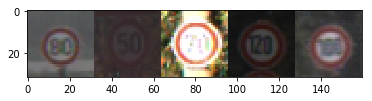

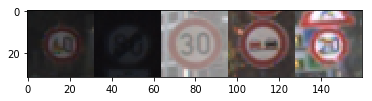

In [16]:
# Load new images, all images have been pre-cropped to square images
imgdir = 'test-images'
X_new_images = []
y_new_images = []
for filename in os.listdir(imgdir):
    if filename.endswith('.ppm'):
        img = mpimg.imread(os.path.join(imgdir, filename))
        img = cv2.resize(img, (32,32), interpolation=cv2.INTER_AREA)
        X_new_images.append(img)        
        y_new_images.append(int(os.path.splitext(filename)[0]))

# Plot the new images
vis = np.concatenate(X_new_images[0:5], axis=1)
plt.imshow(vis)
plt.show()
vis = np.concatenate(X_new_images[5:], axis=1)
plt.imshow(vis)
plt.show()

### Predict the Sign Type for Each Image

INFO:tensorflow:Restoring parameters from ./traffic_classifier


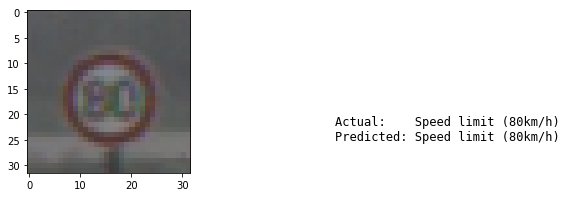

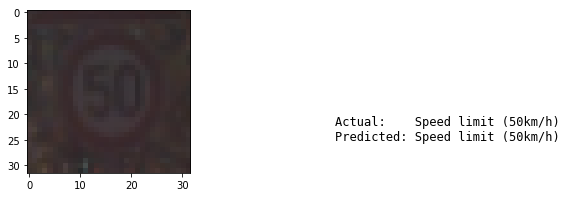

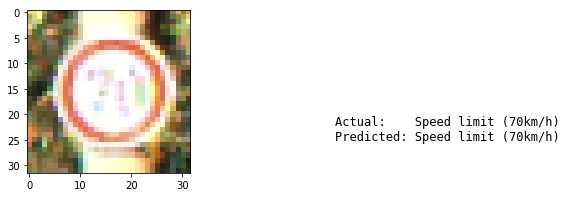

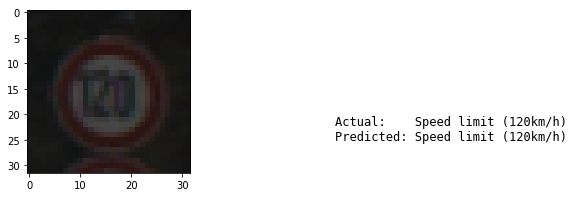

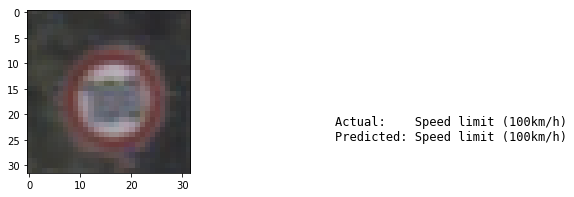

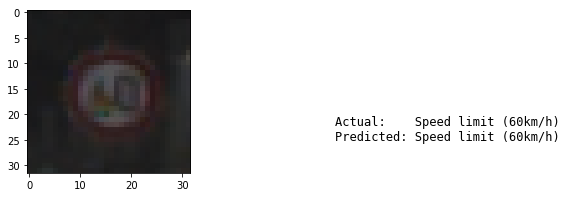

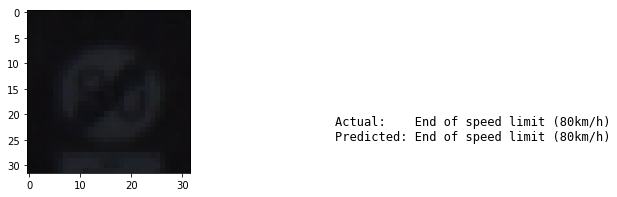

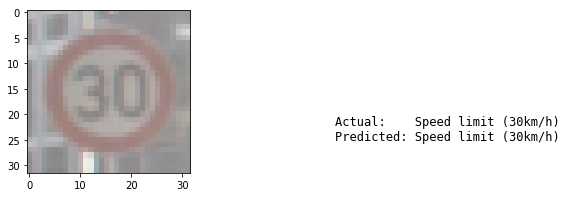

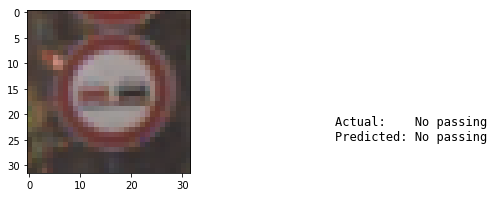

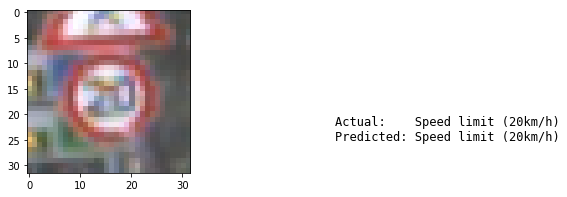

In [33]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.


X_new_images_p = preprocess_features(X_new_images)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predictions = sess.run(prediction, feed_dict={x: X_new_images_p, keep_prob: 1})

    for (i,v) in enumerate(predictions):
        annotation = "Actual:    %s\nPredicted: %s" % (
            id_names[str(y_new_images[i])], id_names[str(v)])
        fig = plt.figure(figsize=(3,3))
        plt.imshow(X_new_images[i])
        plt.annotate(annotation,xy=(0,0), xytext=(60,25), fontsize=12, family='monospace')
        plt.show()

### Analyze Performance

In [18]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.
accuracy = sum(y_new_images == predictions)/len(y_new_images)
print("Accuracy = %4.2f%%" % (100*accuracy))


Accuracy = 100.00%


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [31]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
k = 5
top_k = tf.nn.top_k(tf.nn.softmax(logits), k=k)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    top = sess.run(top_k, feed_dict={x: X_new_images_p, keep_prob:1})

#print(top[0])

for i in range(len(y_new_images)):
    
    print("\n  == Actual ==  |", id_names[str(y_new_images[i])])
    print("----------------|-----------------------")
    for j in range(k):
        print("  %12.10f%% | %s" % (top[0][i][j], id_names[str(top[1][i][j])]))

INFO:tensorflow:Restoring parameters from ./traffic_classifier

  == Actual ==  | Speed limit (80km/h)
----------------|-----------------------
  0.9952079654% | Speed limit (80km/h)
  0.0031240913% | Speed limit (60km/h)
  0.0007239687% | Speed limit (100km/h)
  0.0005267939% | Speed limit (50km/h)
  0.0001862480% | Speed limit (120km/h)

  == Actual ==  | Speed limit (50km/h)
----------------|-----------------------
  0.5568843484% | Speed limit (50km/h)
  0.1268180758% | Speed limit (80km/h)
  0.1051458195% | Speed limit (30km/h)
  0.0364408419% | Speed limit (120km/h)
  0.0244071372% | Speed limit (60km/h)

  == Actual ==  | Speed limit (70km/h)
----------------|-----------------------
  0.9999763966% | Speed limit (70km/h)
  0.0000226687% | No vehicles
  0.0000005465% | Speed limit (50km/h)
  0.0000002882% | Speed limit (30km/h)
  0.0000000266% | Speed limit (100km/h)

  == Actual ==  | Speed limit (120km/h)
----------------|-----------------------
  0.9904190898% | Speed limit (1

### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [20]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input, keep_prob: 1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
    

INFO:tensorflow:Restoring parameters from ./traffic_classifier


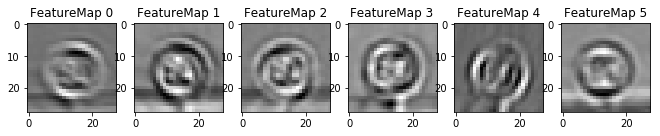

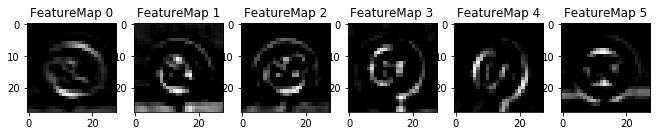

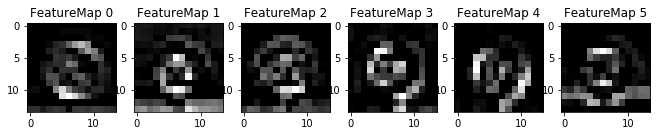

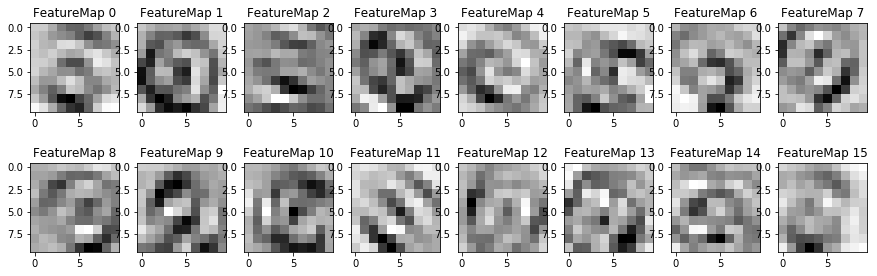

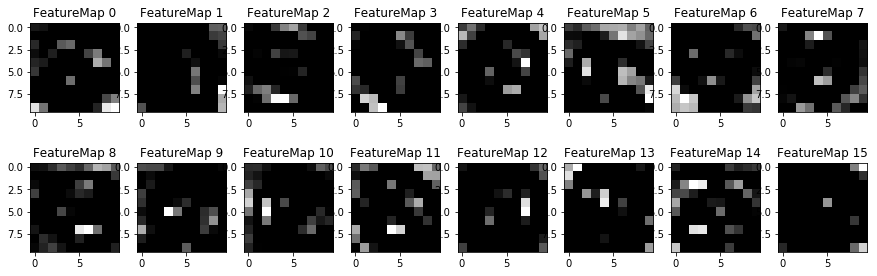

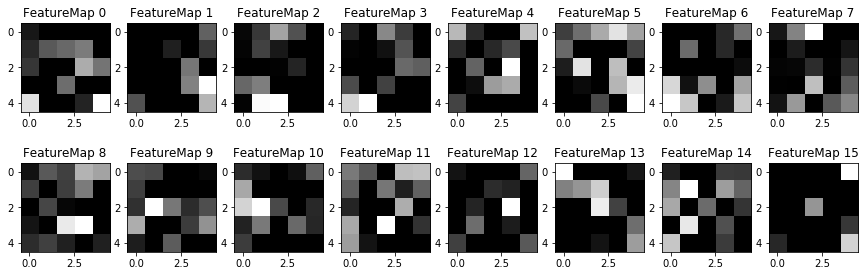

In [21]:
with tf.Session() as sess:
    # Convolution in layer 1 
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    conv1 = sess.graph.get_tensor_by_name('cnn1_conv:0')
    outputFeatureMap(X_new_images_p, conv1)
    plt.show()
    
    # ReLU-activation in layer 1 
    conv1_relu = sess.graph.get_tensor_by_name('cnn1_relu:0')
    outputFeatureMap(X_new_images_p, conv1_relu)
    plt.show()

    # Max-pooling in layer 1 
    conv1_pool = sess.graph.get_tensor_by_name('cnn1_pool:0')
    outputFeatureMap(X_new_images_p, conv1_pool)
    plt.show()
    
    # Convolution in layer 2 
    conv2 = sess.graph.get_tensor_by_name('cnn2_conv:0')
    outputFeatureMap(X_new_images_p, conv2)
    plt.show()
    
    # ReLU-activation in layer 2
    conv2_relu = sess.graph.get_tensor_by_name('cnn2_relu:0')
    outputFeatureMap(X_new_images_p, conv2_relu)
    plt.show()

    # Max-pooling in layer 2
    conv2_pool = sess.graph.get_tensor_by_name('cnn2_pool:0')
    outputFeatureMap(X_new_images_p, conv2_pool)
    plt.show()

    
